Redo the model gain with models in a grid search cross validation loop (not the elasticnetCV)

In [2]:
import pandas as pd
import numpy as np
import matplotlib .pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import os
import datetime
import subprocess
from tqdm import tqdm

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from scipy.stats import pearsonr

print('Last run:', datetime.datetime.now().strftime('%Y-%m-%d'))

Last run: 2024-04-04


# 1. Get dosage from VCF

In [3]:
def get_dosage_matrix(vcf_fn, pos, get_sample_ids=False):
    '''
    Get dosages of a list of given positions
    Params
    - vcf_fn: file name of the vcf to search
    - pos: an array like positions to lookup. For example: ['chr22:10513905-10513905', 'chr22:10514201-10514201']
    - get_sample_ids: will get sample ids and return if True
    Return
    - header: a list sample IDs from vcf
    - dosages: a matrix of dosages in ist form. for example: [[0,1,1], [0,0,0]]
    '''
    chromosome = pos[0].split(':')[0] # Get chromosome number for loggging purpose
    sample_ids, snp_ids = [], []
    
    if get_sample_ids:
        # Get the header line containing sample IDs
        cmd_header = f'tabix -H {os.path.join(vcf_path, vcf_fn)}' 
        sample_ids = subprocess.run(cmd_header.split(),
                                    capture_output=True,
                                    text=True).stdout.rstrip().split('\n')[-1].split(maxsplit=9)[-1].split()
    
    # Get dosages of all SNPs
    # pos = 'chr22:10513905-10513905'
    pos_str = ' '.join(pos)
    cmd = f'tabix {os.path.join(vcf_path, vcf_fn)} {pos_str}' # Find all SNPs at once
    lines = subprocess.run(cmd.split(), capture_output=True, text=True).stdout
    dosages = []
    if len(lines) != 0: # If found something, lines will not be empty
        for line in tqdm(lines.split('\n'), desc=f'# - Getting dosage from {chromosome}'):
            try: # Last item will be a empty string, use try-except to avoid
                dosage = [float(val.split(':')[1]) for val in line.split(maxsplit=9)[-1].split()]
                dosages.append(dosage)
                snp_ids.append(line.split(maxsplit=3)[2])
            except:
                continue
    return sample_ids, snp_ids, dosages


In [3]:
vcf_path='/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_sample_vcfs/202312_redo_training_vcfs'
vcf_fn = 'max_unrelated_set_chr22.vcf.gz'
sample_ids, snp_ids, dosages = get_dosage_matrix(vcf_fn=os.path.join(vcf_path, vcf_fn), pos=['chr22:10513905-10513905', 'chr22:10526288-10526288'])

# - Getting dosage from chr22: 100%|████████████| 3/3 [00:00<00:00, 1309.63it/s]


# 2. Look up dosages of a list of SNPs filtered by GWAS pvalue

In [4]:
def get_dosage_of_snps_from_gwas_output(vcf_path, vcf_fn, snp_fn):
    '''
    Given a (filtered) GWAS output file, get dosages of all SNPs from the file
    Params
    - vcf_path, vcf_fn: path and file name to the vcfs. vcf_fn must have chromosome number replaced with *, such as 'max_unrelated_set_chr*.vcf.gz'
    - snp_fn: file name to the filtered SNPs, such as '/data100t1/home/wanying/CCHC/lipidomics/TG-123.txt'
    Return
    Return None if CHR and POS are not columns in the SNP file.
    Otherwise, return a Dataframe of dosage with sample IDs and SNP IDs labeled.
    Results have shape of sample x features(SNPs)
    
    # Path and file name examples
    vcf_path='/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_sample_vcfs/202312_redo_training_vcfs'
    vcf_fn = 'max_unrelated_set_chr*.vcf.gz' # Replace * with chromosome number in the loop
    snp_path = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_species_filter_by_pval_1e-05'
    snp_fn = 'TG-58:8-_[NL-22:6]_SNPs.pval_1e-05.txt'
    '''
    
    df_snps = pd.read_csv(snp_fn, sep='\t', dtype='str')
    
    # 'CHR' and 'POS' columns shoulbe found in df_snps.columns
    if not 'CHR' in df_snps.columns:
        print('# Error: Column CHR not found in the filtered SNP file')
        return
    if not 'POS' in df_snps.columns:
        print('# Error: Column CHR not found in the filtered SNP file')
        return
    
    # Get list of positions from the SNP dataframe
    df_snps['position_for_tabix'] = 'chr' + df_snps['CHR'] + ':' + df_snps['POS'] + '-' + df_snps['POS']
    dosage_all, snp_ids_all = [], [] # Store dosages from each chromosome

    for i, (chr_num, df) in enumerate(df_snps.groupby('CHR')):
        positions = df['position_for_tabix'].values
        if i==0:
            sample_ids, snp_ids, dosages = get_dosage_matrix(vcf_fn=os.path.join(vcf_path, vcf_fn.replace('*', chr_num)),
                                                             pos=positions,
                                                             get_sample_ids=True)
        else:
            _, snp_ids, dosages = get_dosage_matrix(vcf_fn=os.path.join(vcf_path, vcf_fn.replace('*', chr_num)),
                                                             pos=positions)
        dosage_all += dosages
        snp_ids_all += snp_ids

    
    # df_dosage = pd.DataFrame(data=np.array(dosage_all), columns=header, index=snp_ids_all).T
    return pd.DataFrame(data=np.array(dosage_all), columns=sample_ids, index=snp_ids_all).T

In [5]:
vcf_path='/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_sample_vcfs/202312_redo_training_vcfs'
vcf_fn = 'max_unrelated_set_chr*.vcf.gz' # Replace * with chromosome number in the loop
snp_path = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_species_filter_by_pval_1e-05'
# snp_fn = 'TG-58:8-_[NL-22:6]_SNPs.pval_1e-05.txt'
snp_fn = 'AC-10:0-_SNPs.pval_1e-05.txt'
df_dosage = get_dosage_of_snps_from_gwas_output(vcf_path, vcf_fn, os.path.join(snp_path, snp_fn))
print(df_dosage.shape)
display(df_dosage.head(2))

# - Getting dosage from chr9: 100%|███████████████████████████████████████████████████| 7/7 [00:00<00:00, 854.98it/s]

(1607, 468)


,chr1:75631359:C:T,chr1:75631396:A:G,chr1:75632337:TA:T,chr1:75634035:G:A,chr1:75636236:T:C,chr1:75637345:C:T,chr1:75638072:T:C,chr1:75640990:T:C,chr1:75641276:T:A,chr1:75641277:T:C,...,chr8:133674584:C:T,chr8:133675560:A:G,chr8:143940668:A:C,chr8:143978279:G:C,chr9:71991370:C:G,chr9:71992971:G:A,chr9:71994837:T:C,chr9:71995056:A:G,chr9:72008497:A:G,chr9:76065054:T:C
HD0280_HA0023,0.020,0.020,0.000,0.001,1.972,0.000,2.0,0.0,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.147,1.0
BD2180_BD6180,1.994,1.994,1.994,0.000,0.000,1.994,0.0,2.0,1.994,1.994,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,1.0


# 3. Load lipidomics measures, match IDs with genotype file

In [38]:
for lip_type in ['class', 'species']:
    fn_lipid = f'/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_{lip_type}_with_covar.no_dup.residual.all.txt'
    df_lipid = pd.read_csv(fn_lipid, sep='\t')
    display(df_lipid.head(2))

    # Change IDs to be the same ID format in genotype file
    fn_id_mapping = '/data100t1/home/wanying/CCHC/doc/samples_IDs/202211_merged_RNA_lipid_protein_genotype_mapping_and_availability.txt'
    df_id_mapping = pd.read_csv(fn_id_mapping, sep='\t')[['RRID', 'genotype_ID', 'lipidomic']].dropna().drop_duplicates(subset='RRID')
    display(df_id_mapping.head(2))

    df_lipid_id_matched = df_id_mapping.merge(df_lipid, on='RRID').drop(columns=['RRID', 'LABID', 'lipidomic'])
    display(df_lipid_id_matched.head(2))
    # Save ID matched file for future use
    df_lipid_id_matched.to_csv(f'/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_{lip_type}_genotype_id_matched.no_dup.residual.all.txt',
                               sep='\t', index=False)

,RRID,LABID,Sph,S1P,dhCer,Cer(d),Cer(m),C1P,HexCer,Hex2Cer,...,AC-OH,BA,DG,DG(O),TG(SIM),TG [NL],TG(O),TG(O) [NL],Ubiquinone,OxSpecies
0,BD0010,10Y0021,0.356422,1.227750,0.181115,0.603480,0.613756,1.064128,1.083855,0.348314,...,1.292170,-0.639428,-0.642785,-0.150239,-0.484137,-0.465619,0.695025,0.596011,1.166953,0.318425
1,BD0382,10Y0381,0.572306,1.201568,-0.371745,0.239449,0.279500,-0.510061,0.106619,-0.603041,...,1.820526,-0.033763,0.326699,0.635398,0.442119,0.418341,-1.176788,-1.069051,-0.165116,-0.797598


,RRID,genotype_ID,lipidomic
9,BD0009,BD0009_BD4009,10Y0308
11,BD0010,BD0010_BD4010,10Y0021


,genotype_ID,Sph,S1P,dhCer,Cer(d),Cer(m),C1P,HexCer,Hex2Cer,Hex3Cer,...,AC-OH,BA,DG,DG(O),TG(SIM),TG [NL],TG(O),TG(O) [NL],Ubiquinone,OxSpecies
0,BD0009_BD4009,0.314270,1.283476,1.627941,0.119952,0.263180,1.142337,-0.072391,1.828888,0.818142,...,-0.578067,0.077477,-1.895045,-0.625995,-1.798835,-1.746141,-0.090664,-0.196743,0.033647,1.205431
1,BD0010_BD4010,0.356422,1.227750,0.181115,0.603480,0.613756,1.064128,1.083855,0.348314,1.700467,...,1.292170,-0.639428,-0.642785,-0.150239,-0.484137,-0.465619,0.695025,0.596011,1.166953,0.318425


,RRID,LABID,Sph(d18:1),Sph(d18:2),S1P(d16:1),S1P(d18:0),S1P(d18:1),S1P(d18:2),dhCer(d18:0/16:0),dhCer(d18:0/18:0),...,TG(O-54:4) [NL-18:2],Ubiquinone,CE(18:2) [+OH],CE(20:4) [+OH],LPC(18:2) [+OH],LPC(20:4) [+OH],LPC(22:6) [+OH],PC(34:2) [+OH],PC(36:4) [+OH],PC(38:6) [+OH]
0,BD0010,10Y0021,0.229686,0.996114,1.032505,0.261368,1.290543,1.485298,0.587218,0.811655,...,0.533136,1.166953,0.124958,1.067570,1.277118,1.135830,0.895316,0.781975,1.030432,0.476622
1,BD0382,10Y0381,0.599855,0.220383,-0.410949,1.318587,1.176857,0.823059,-0.953008,-0.187285,...,-0.987629,-0.165116,-0.966227,0.453366,0.127089,-0.045657,-0.168233,0.381594,-0.810531,-0.826416


,RRID,genotype_ID,lipidomic
9,BD0009,BD0009_BD4009,10Y0308
11,BD0010,BD0010_BD4010,10Y0021


,genotype_ID,Sph(d18:1),Sph(d18:2),S1P(d16:1),S1P(d18:0),S1P(d18:1),S1P(d18:2),dhCer(d18:0/16:0),dhCer(d18:0/18:0),dhCer(d18:0/20:0),...,TG(O-54:4) [NL-18:2],Ubiquinone,CE(18:2) [+OH],CE(20:4) [+OH],LPC(18:2) [+OH],LPC(20:4) [+OH],LPC(22:6) [+OH],PC(34:2) [+OH],PC(36:4) [+OH],PC(38:6) [+OH]
0,BD0009_BD4009,0.275791,0.549473,0.721941,1.557758,1.322990,0.270136,1.181562,-0.364001,2.392771,...,-0.065122,0.033647,1.205709,0.897438,0.353739,0.117593,-0.357713,0.627687,-0.706694,-0.918218
1,BD0010_BD4010,0.229686,0.996114,1.032505,0.261368,1.290543,1.485298,0.587218,0.811655,0.345900,...,0.533136,1.166953,0.124958,1.067570,1.277118,1.135830,0.895316,0.781975,1.030432,0.476622


# 4. Match sample order in lipidomics measures with genotype dosage

In [6]:
fn_lipid = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/lipid_species_genotype_id_matched.no_dup.residual.all.txt'
df_lipid = pd.read_csv(fn_lipid, sep='\t')

lipid = 'AC(10:0)'
id_col = df_lipid.columns[0]
df_merged = df_lipid[[id_col, lipid]].merge(df_dosage.reset_index(), left_on=id_col, right_on='index')

In [7]:
df_merged.head(5)

,genotype_ID,AC(10:0),index,chr1:75631359:C:T,chr1:75631396:A:G,chr1:75632337:TA:T,chr1:75634035:G:A,chr1:75636236:T:C,chr1:75637345:C:T,chr1:75638072:T:C,...,chr8:133674584:C:T,chr8:133675560:A:G,chr8:143940668:A:C,chr8:143978279:G:C,chr9:71991370:C:G,chr9:71992971:G:A,chr9:71994837:T:C,chr9:71995056:A:G,chr9:72008497:A:G,chr9:76065054:T:C
0,BD0009_BD4009,-1.448175,BD0009_BD4009,0.000,0.000,0.000,0.0,0.99,0.000,1.0,...,0.0,0.0,0.0,0.0,1.0,0.982,0.986,0.986,0.001,0.999
1,BD0058_BD4058,-0.316260,BD0058_BD4058,1.000,1.000,1.000,0.0,1.00,1.000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.975
2,BD0231_BD4231,0.673815,BD0231_BD4231,0.994,0.993,0.994,0.0,1.00,0.994,1.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,1.995
3,BD0237_BD04237,0.786607,BD0237_BD04237,2.000,2.000,2.000,1.0,0.00,2.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,1.000
4,BD0238_BD4238,-0.194754,BD0238_BD4238,1.000,1.000,1.000,0.0,0.00,1.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.999,1.000


# 5. Train model

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from scipy.stats import pearsonr

In [9]:
n_alphas = 100
regr = ElasticNetCV(cv=10, alphas=np.linspace(0, 0.5, 100, endpoint=False), random_state=0)
X, y = df_merged.drop(columns=[lipid, id_col, 'index']), df_merged[lipid]
regr.fit(X, y )

/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351.8294808712444, tolerance: 0.1389574224734222
  model = cd_fast.enet_coordinate_descent_gram(
/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklear

ElasticNetCV(alphas=array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495]),
             cv=10, random_state=0)

In [10]:
regr.alpha_

0.005

0.6251393589698377


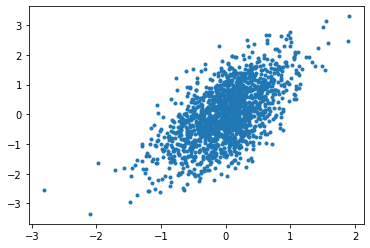

In [11]:
pred = regr.predict(X)
print(pearsonr(pred, y)[0])
fig, ax = plt.subplots()
ax.plot(pred, y, ls='', marker='.')

0.6251393589698377


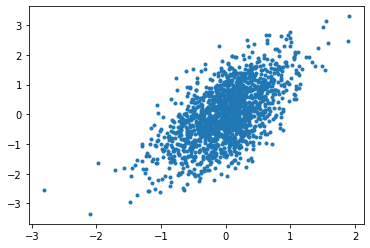

In [12]:
pred = regr.predict(X)
print(pearsonr(pred, y)[0])
fig, ax = plt.subplots()
ax.plot(pred, y, ls='', marker='.')

In [13]:
# Use gridCV
model = ElasticNet(random_state=0, alpha=0)
model.fit(X ,y)
# n_alpha = 100 # Number of alphas to tune
# parameters = {'apha':('linear', 'rbf'), 'l1_ratio':[0.5]}
# search = GridSearchCV(model, parameters, cv=10)

/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.980e+02, tolerance: 1.514e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/R

ElasticNet(alpha=0, random_state=0)

0.6251393589698377


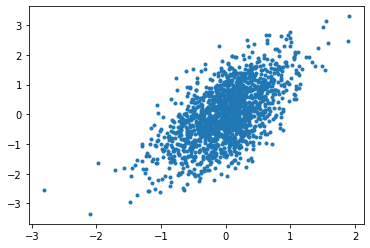

In [14]:
pred = regr.predict(X)
print(pearsonr(pred, y)[0])
fig, ax = plt.subplots()
ax.plot(pred, y, ls='', marker='.')

# 2024/04/04 Try traing elastic net on the dosage file pulled by phillip
The lipid to test is AC-10_0-

## (1) Do the same step and use the same input files as Phillip's R code

In [46]:
lipid= 'AC-10_0-'
fn_dosage = '/data100t1/home/wanying/CCHC/lipidomics/20240204_rerun_to_compare_with_phillip/Phillip_rerun/Dosages/Wanying_Dosages/AC-10_0-_Wanying_Dosages.csv'
df_dosage = pd.read_csv(fn_dosage)
print(df_dosage.shape)
display(df_dosage.head())

(1607, 457)


,IID,chr1:75631359:C:T,chr1:75631396:A:G,chr1:75632337:TA:T,chr1:75634035:G:A,chr1:75636236:T:C,chr1:75637345:C:T,chr1:75638072:T:C,chr1:75640990:T:C,chr1:75641276:T:A,...,chr8:133674584:C:T,chr8:133675560:A:G,chr8:143940668:A:C,chr8:143978279:G:C,chr9:71991370:C:G,chr9:71992971:G:A,chr9:71994837:T:C,chr9:71995056:A:G,chr9:72008497:A:G,chr9:76065054:T:C
0,BA0185,1.995,1.995,1.995,1.0,0.00,1.995,0.0,1.0,0.999,...,0.0,0.0,0.0,0.0,1.0,0.988,0.991,0.991,1.000,0.000
1,BD0009_BD4009,0.000,0.000,0.000,0.0,0.99,0.000,1.0,0.0,0.000,...,0.0,0.0,0.0,0.0,1.0,0.982,0.986,0.986,0.001,0.999
2,BD0058_BD4058,1.000,1.000,1.000,0.0,1.00,1.000,1.0,1.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.975
3,BD0231_BD4231,0.994,0.993,0.994,0.0,1.00,0.994,1.0,1.0,0.994,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,1.995
4,BD0237_BD04237,2.000,2.000,2.000,1.0,0.00,2.000,0.0,2.0,2.000,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,1.000


In [9]:
fn_lipid_species = '/data100t1/home/wanying/CCHC/lipidomics/20240204_rerun_to_compare_with_phillip/Phillip_rerun/Expression/lipid_species_with_covar.no_dup.residual.train.matched_gwas_names.txt'
df_lipid_species = pd.read_csv(fn_lipid_species, sep='\t')
print(df_lipid_species.shape)
display(df_lipid_species.head())

(1606, 831)


,IID,Sph-d18_1-,Sph-d18_2-,S1P-d16_1-,S1P-d18_0-,S1P-d18_1-,S1P-d18_2-,dhCer-d18_0-16_0-,dhCer-d18_0-18_0-,dhCer-d18_0-20_0-,...,TG-O-54_4-_[NL-18_2],Ubiquinone,CE-18_2-_[+OH],CE-20_4-_[+OH],LPC-18_2-_[+OH],LPC-20_4-_[+OH],LPC-22_6-_[+OH],PC-34_2-_[+OH],PC-36_4-_[+OH],PC-38_6-_[+OH]
0,BD0009_10Y0308,0.275791,0.549473,0.721941,1.557758,1.322990,0.270136,1.181562,-0.364001,2.392771,...,-0.065122,0.033647,1.205709,0.897438,0.353739,0.117593,-0.357713,0.627687,-0.706694,-0.918218
1,BD0058_10Y0246,2.874146,2.689427,0.118917,1.633277,1.847306,1.474152,0.553985,0.332099,1.497080,...,-0.411708,0.301072,1.222128,1.754571,1.206090,1.780087,1.669920,-0.772111,1.120944,0.108486
2,BD0231_10Y0261,0.060532,0.121371,0.625301,1.796344,1.399492,1.036197,0.849611,0.892921,1.107405,...,0.737043,0.460402,-1.191632,-0.104913,-1.402158,-0.185926,-0.428001,-0.408784,1.337990,0.669756
3,BD0237_10Y0245,0.152859,-0.178649,0.734423,1.247500,1.398077,1.519474,0.976871,0.608833,0.535158,...,0.936259,0.856916,1.559515,1.224542,0.646028,0.976723,1.393470,1.934893,0.503205,1.299069
4,BD0238_BD6128,1.357321,1.211258,1.325999,0.927392,1.382660,0.661690,-0.335090,-0.420693,0.048514,...,1.476330,0.322285,0.695024,0.644652,1.036605,1.460339,1.427163,0.532508,0.163532,-0.201263


In [11]:
# Merge genoytpe and expression (so IDs align)
df_merged = df_lipid_species[['IID', lipid]].merge(df_dosage, on='IID')
print(df_merged.shape)
display(df_merged.head())

# So after the merge, 1606-1458=148 samples were dropped due to what reason?

(1458, 458)


,IID,AC-10_0-,chr1:75631359:C:T,chr1:75631396:A:G,chr1:75632337:TA:T,chr1:75634035:G:A,chr1:75636236:T:C,chr1:75637345:C:T,chr1:75638072:T:C,chr1:75640990:T:C,...,chr8:133674584:C:T,chr8:133675560:A:G,chr8:143940668:A:C,chr8:143978279:G:C,chr9:71991370:C:G,chr9:71992971:G:A,chr9:71994837:T:C,chr9:71995056:A:G,chr9:72008497:A:G,chr9:76065054:T:C
0,BD0477_10Y0234,1.551192,2.000,2.000,2.000,1.00,0.0,2.000,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.0
1,BD0524_10Y0253,0.473027,1.973,1.973,1.969,0.18,0.0,1.956,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,1.00,1.000,1.000,0.001,0.0
2,BD0598_10Y0259,0.590846,2.000,2.000,2.000,1.00,0.0,2.000,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.99,0.989,0.989,0.820,0.0
3,BD0775_10Y0325,-0.013539,2.000,2.000,2.000,2.00,0.0,2.000,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,1.00,1.000,1.000,1.000,0.0
4,BD1141_10Y0275,0.267984,2.000,2.000,2.000,0.00,0.0,2.000,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,1.00,1.000,1.000,1.000,1.0


In [21]:
# Train elastic net model
n_alphas = 100
# regr = ElasticNetCV(cv=10, alphas=np.linspace(0, 0.5, 100, endpoint=False), random_state=0)
regr = ElasticNetCV(cv=10, n_alphas=n_alphas, random_state=0)
X, y = df_merged.drop(columns=[lipid, 'IID']), df_merged[lipid]
regr.fit(X, y )

/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20364445715688362, tolerance: 0.12382143910796908
  model = cd_fast.enet_coordinate_descent_gram(
/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2990076533985757, tolerance: 0.12382143910796908
  model = cd_fast.enet_coordinate_descent_gram(
/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3178255922216522, tolerance: 0.12382143910796908
  model = cd_fast.enet_coordinate_descent_gram(
/data100t1/home/wanying/.local/lib/p

ElasticNetCV(cv=10, random_state=0)

# pearson r 0.668316071093937, pvalue 2.5173627248052254e-189


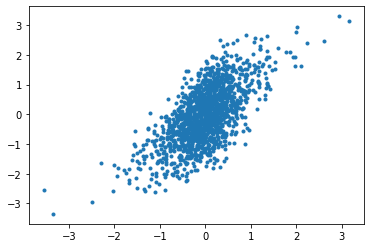

In [22]:
pred = regr.predict(X)
print('# pearson r %s, pvalue %s' % pearsonr(pred, y))
fig, ax = plt.subplots()
ax.plot(pred, y, ls='', marker='.')

# So this looks good! but why

In [ ]:
# TBD
# Check performance on the testing set
# fn_test = ''

## (2) Use the same dosage file, but with the lipid trait I labled with genotype IDs

In [31]:
fn_lipid_species_wz_labeled = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait/lipid_species_ID_matched.no_dup.residual.train.txt'
df_lipid_species_wz_labeled = pd.read_csv(fn_lipid_species_wz_labeled, sep='\t').rename(columns={'genotype_ID':'IID'})
print(df_lipid_species_wz_labeled.shape)
display(df_lipid_species_wz_labeled.head(2))


(1606, 833)


,RRID,IID,LABID,Sph(d18:1),Sph(d18:2),S1P(d16:1),S1P(d18:0),S1P(d18:1),S1P(d18:2),dhCer(d18:0/16:0),...,TG(O-54:4) [NL-18:2],Ubiquinone,CE(18:2) [+OH],CE(20:4) [+OH],LPC(18:2) [+OH],LPC(20:4) [+OH],LPC(22:6) [+OH],PC(34:2) [+OH],PC(36:4) [+OH],PC(38:6) [+OH]
0,BD0009,BD0009_BD4009,10Y0308,0.275791,0.549473,0.721941,1.557758,1.322990,0.270136,1.181562,...,-0.065122,0.033647,1.205709,0.897438,0.353739,0.117593,-0.357713,0.627687,-0.706694,-0.918218
1,BD0058,BD0058_BD4058,10Y0246,2.874146,2.689427,0.118917,1.633277,1.847306,1.474152,0.553985,...,-0.411708,0.301072,1.222128,1.754571,1.206090,1.780087,1.669920,-0.772111,1.120944,0.108486


In [37]:
# Merge Pillip pulled dosage with my labeled lipidomics traits
# No sample dropped
lipid = 'AC(10:0)' # AC-10_0-
df_merged_wz = df_lipid_species_wz_labeled[['IID', lipid]].merge(df_dosage, on='IID')
print(df_merged_wz.shape)
display(df_merged_wz.head(2))


(1606, 458)


,IID,AC(10:0),chr1:75631359:C:T,chr1:75631396:A:G,chr1:75632337:TA:T,chr1:75634035:G:A,chr1:75636236:T:C,chr1:75637345:C:T,chr1:75638072:T:C,chr1:75640990:T:C,...,chr8:133674584:C:T,chr8:133675560:A:G,chr8:143940668:A:C,chr8:143978279:G:C,chr9:71991370:C:G,chr9:71992971:G:A,chr9:71994837:T:C,chr9:71995056:A:G,chr9:72008497:A:G,chr9:76065054:T:C
0,BD0009_BD4009,-1.448175,0.0,0.0,0.0,0.0,0.99,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.982,0.986,0.986,0.001,0.999
1,BD0058_BD4058,-0.316260,1.0,1.0,1.0,0.0,1.00,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.975


In [40]:
# Train elastic net model
n_alphas = 100
# regr = ElasticNetCV(cv=10, alphas=np.linspace(0, 0.5, 100, endpoint=False), random_state=0)
regr = ElasticNetCV(cv=10, n_alphas=n_alphas, random_state=0)
X, y = df_merged_wz.drop(columns=[lipid, 'IID']), df_merged_wz[lipid]
regr.fit(X, y )

/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15360474433941818, tolerance: 0.13895742247342216
  model = cd_fast.enet_coordinate_descent_gram(
/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2368281065866995, tolerance: 0.13895742247342216
  model = cd_fast.enet_coordinate_descent_gram(
/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39581357474560264, tolerance: 0.13895742247342216
  model = cd_fast.enet_coordinate_descent_gram(
/data100t1/home/wanying/.local/lib/

ElasticNetCV(cv=10, random_state=0)

# pearson r 0.652854817365541, pvalue 9.96007552784364e-196


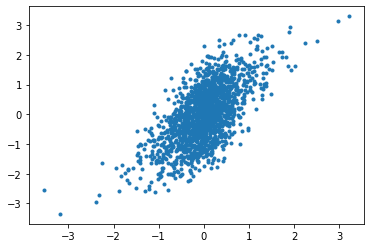

In [41]:
pred = regr.predict(X)
print('# pearson r %s, pvalue %s' % pearsonr(pred, y))
fig, ax = plt.subplots()
ax.plot(pred, y, ls='', marker='.')

# Still looks good. So what whent wrong?

## (3) Use my method to pull dosage, then train the model
Based on code from as 1-5

In [43]:
def get_dosage_matrix(vcf_fn, pos, get_sample_ids=False):
    '''
    Get dosages of a list of given positions
    Params
    - vcf_fn: file name of the vcf to search
    - pos: an array like positions to lookup. For example: ['chr22:10513905-10513905', 'chr22:10514201-10514201']
    - get_sample_ids: will get sample ids and return if True
    Return
    - header: a list sample IDs from vcf
    - dosages: a matrix of dosages in ist form. for example: [[0,1,1], [0,0,0]]
    '''
    chromosome = pos[0].split(':')[0] # Get chromosome number for loggging purpose
    sample_ids, snp_ids = [], []
    
    if get_sample_ids:
        # Get the header line containing sample IDs
        cmd_header = f'tabix -H {os.path.join(vcf_path, vcf_fn)}' 
        sample_ids = subprocess.run(cmd_header.split(),
                                    capture_output=True,
                                    text=True).stdout.rstrip().split('\n')[-1].split(maxsplit=9)[-1].split()
    
    # Get dosages of all SNPs
    # pos = 'chr22:10513905-10513905'
    pos_str = ' '.join(pos)
    cmd = f'tabix {os.path.join(vcf_path, vcf_fn)} {pos_str}' # Find all SNPs at once
    lines = subprocess.run(cmd.split(), capture_output=True, text=True).stdout
    dosages = []
    if len(lines) != 0: # If found something, lines will not be empty
        for line in tqdm(lines.split('\n'), desc=f'# - Getting dosage from {chromosome}'):
            try: # Last item will be a empty string, use try-except to avoid
                dosage = [float(val.split(':')[1]) for val in line.split(maxsplit=9)[-1].split()]
                dosages.append(dosage)
                snp_ids.append(line.split(maxsplit=3)[2])
            except:
                continue
    return sample_ids, snp_ids, dosages


In [44]:
def get_dosage_of_snps_from_gwas_output(vcf_path, vcf_fn, snp_fn):
    '''
    Given a (filtered) GWAS output file, get dosages of all SNPs from the file
    Params
    - vcf_path, vcf_fn: path and file name to the vcfs. vcf_fn must have chromosome number replaced with *, such as 'max_unrelated_set_chr*.vcf.gz'
    - snp_fn: file name to the filtered SNPs, such as '/data100t1/home/wanying/CCHC/lipidomics/TG-123.txt'
    Return
    Return None if CHR and POS are not columns in the SNP file.
    Otherwise, return a Dataframe of dosage with sample IDs and SNP IDs labeled.
    Results have shape of sample x features(SNPs)
    
    # Path and file name examples
    vcf_path='/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_sample_vcfs/202312_redo_training_vcfs'
    vcf_fn = 'max_unrelated_set_chr*.vcf.gz' # Replace * with chromosome number in the loop
    snp_path = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_species_filter_by_pval_1e-05'
    snp_fn = 'TG-58:8-_[NL-22:6]_SNPs.pval_1e-05.txt'
    '''
    
    df_snps = pd.read_csv(snp_fn, sep='\t', dtype='str')
    
    # 'CHR' and 'POS' columns shoulbe found in df_snps.columns
    if not 'CHR' in df_snps.columns:
        print('# Error: Column CHR not found in the filtered SNP file')
        return
    if not 'POS' in df_snps.columns:
        print('# Error: Column CHR not found in the filtered SNP file')
        return
    
    # Get list of positions from the SNP dataframe
    df_snps['position_for_tabix'] = 'chr' + df_snps['CHR'] + ':' + df_snps['POS'] + '-' + df_snps['POS']
    dosage_all, snp_ids_all = [], [] # Store dosages from each chromosome

    for i, (chr_num, df) in enumerate(df_snps.groupby('CHR')):
        positions = df['position_for_tabix'].values
        if i==0:
            sample_ids, snp_ids, dosages = get_dosage_matrix(vcf_fn=os.path.join(vcf_path, vcf_fn.replace('*', chr_num)),
                                                             pos=positions,
                                                             get_sample_ids=True)
        else:
            _, snp_ids, dosages = get_dosage_matrix(vcf_fn=os.path.join(vcf_path, vcf_fn.replace('*', chr_num)),
                                                             pos=positions)
        dosage_all += dosages
        snp_ids_all += snp_ids

    
    # df_dosage = pd.DataFrame(data=np.array(dosage_all), columns=header, index=snp_ids_all).T
    return pd.DataFrame(data=np.array(dosage_all), columns=sample_ids, index=snp_ids_all).T

In [47]:
vcf_path='/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_sample_vcfs/202312_redo_training_vcfs'
vcf_fn = 'max_unrelated_set_chr*.vcf.gz' # Replace * with chromosome number in the loop
snp_path = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_species_filter_by_pval_1e-05'
snp_fn = 'AC-10:0-_SNPs.pval_1e-05.txt'
df_dosage_wz = get_dosage_of_snps_from_gwas_output(vcf_path, vcf_fn, os.path.join(snp_path, snp_fn))
print(df_dosage_wz.shape)
display(df_dosage_wz.head(2))

# - Getting dosage from chr9: 100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 856.33it/s]

(1607, 468)


,chr1:75631359:C:T,chr1:75631396:A:G,chr1:75632337:TA:T,chr1:75634035:G:A,chr1:75636236:T:C,chr1:75637345:C:T,chr1:75638072:T:C,chr1:75640990:T:C,chr1:75641276:T:A,chr1:75641277:T:C,...,chr8:133674584:C:T,chr8:133675560:A:G,chr8:143940668:A:C,chr8:143978279:G:C,chr9:71991370:C:G,chr9:71992971:G:A,chr9:71994837:T:C,chr9:71995056:A:G,chr9:72008497:A:G,chr9:76065054:T:C
HD0280_HA0023,0.020,0.020,0.000,0.001,1.972,0.000,2.0,0.0,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.147,1.0
BD2180_BD6180,1.994,1.994,1.994,0.000,0.000,1.994,0.0,2.0,1.994,1.994,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,1.0


In [48]:
df_dosage_wz

,chr1:75631359:C:T,chr1:75631396:A:G,chr1:75632337:TA:T,chr1:75634035:G:A,chr1:75636236:T:C,chr1:75637345:C:T,chr1:75638072:T:C,chr1:75640990:T:C,chr1:75641276:T:A,chr1:75641277:T:C,...,chr8:133674584:C:T,chr8:133675560:A:G,chr8:143940668:A:C,chr8:143978279:G:C,chr9:71991370:C:G,chr9:71992971:G:A,chr9:71994837:T:C,chr9:71995056:A:G,chr9:72008497:A:G,chr9:76065054:T:C
HD0280_HA0023,0.020,0.020,0.000,0.001,1.972,0.000,2.0,0.0,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.147,1.00
BD2180_BD6180,1.994,1.994,1.994,0.000,0.000,1.994,0.0,2.0,1.994,1.994,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,1.00
BD2179_BD6179,1.000,1.000,1.000,0.000,0.991,1.000,1.0,1.0,1.000,1.000,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.00
BD2288_BD6288,1.999,1.999,1.999,1.000,0.000,1.999,0.0,2.0,1.999,1.999,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,1.000,0.00
HD0119_HD4119,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.0,1.000,1.000,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BD2606_BD6606,1.000,1.000,1.000,1.000,0.000,1.000,0.0,1.0,1.000,1.000,...,0.0,0.0,0.0,0.0,1.0,0.000,1.000,0.000,0.000,1.00
LD0082_LD4082,0.998,0.998,0.998,0.000,0.000,0.998,0.0,1.0,0.998,0.998,...,0.0,0.0,0.0,0.0,1.0,0.999,0.999,0.999,1.998,0.00
BD2833_BD6833,0.999,0.999,0.999,0.000,0.998,0.999,1.0,1.0,0.999,0.999,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,1.96
BD3346_BA0352,1.999,1.999,1.999,1.999,0.000,1.999,0.0,2.0,1.999,1.999,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,1.99


In [49]:
df_dosage

,IID,chr1:75631359:C:T,chr1:75631396:A:G,chr1:75632337:TA:T,chr1:75634035:G:A,chr1:75636236:T:C,chr1:75637345:C:T,chr1:75638072:T:C,chr1:75640990:T:C,chr1:75641276:T:A,...,chr8:133674584:C:T,chr8:133675560:A:G,chr8:143940668:A:C,chr8:143978279:G:C,chr9:71991370:C:G,chr9:71992971:G:A,chr9:71994837:T:C,chr9:71995056:A:G,chr9:72008497:A:G,chr9:76065054:T:C
0,BA0185,1.995,1.995,1.995,1.000,0.00,1.995,0.0,1.0,0.999,...,0.0,0.0,0.0,0.0,1.0,0.988,0.991,0.991,1.000,0.000
1,BD0009_BD4009,0.000,0.000,0.000,0.000,0.99,0.000,1.0,0.0,0.000,...,0.0,0.0,0.0,0.0,1.0,0.982,0.986,0.986,0.001,0.999
2,BD0058_BD4058,1.000,1.000,1.000,0.000,1.00,1.000,1.0,1.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.975
3,BD0231_BD4231,0.994,0.993,0.994,0.000,1.00,0.994,1.0,1.0,0.994,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,1.995
4,BD0237_BD04237,2.000,2.000,2.000,1.000,0.00,2.000,0.0,2.0,2.000,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1602,LD0698_LA0410,2.000,2.000,2.000,1.000,0.00,2.000,0.0,2.0,2.000,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,1.000
1603,LD0700_LA0408,1.993,1.993,1.995,0.968,0.00,1.995,0.0,2.0,1.995,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.998,0.986
1604,LD0703_LA0413,1.986,1.986,1.984,1.000,0.00,1.980,0.0,2.0,1.978,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000
1605,LD0704_LA0414,1.997,1.997,1.997,0.000,0.00,1.997,0.0,2.0,1.997,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,2.000


In [55]:
lipid = 'AC(10:0)'

df_merged_method3 = df_lipid_species_wz_labeled[['IID', lipid]].merge(df_dosage_wz.reset_index(),
                                                              left_on='IID', right_on='index')
print(df_merged_method3.shape)
display(df_merged_method3.head(2))

(1606, 471)


,IID,AC(10:0),index,chr1:75631359:C:T,chr1:75631396:A:G,chr1:75632337:TA:T,chr1:75634035:G:A,chr1:75636236:T:C,chr1:75637345:C:T,chr1:75638072:T:C,...,chr8:133674584:C:T,chr8:133675560:A:G,chr8:143940668:A:C,chr8:143978279:G:C,chr9:71991370:C:G,chr9:71992971:G:A,chr9:71994837:T:C,chr9:71995056:A:G,chr9:72008497:A:G,chr9:76065054:T:C
0,BD0009_BD4009,-1.448175,BD0009_BD4009,0.0,0.0,0.0,0.0,0.99,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.982,0.986,0.986,0.001,0.999
1,BD0058_BD4058,-0.316260,BD0058_BD4058,1.0,1.0,1.0,0.0,1.00,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.975


In [57]:
# Train the model
n_alphas = 100
regr = ElasticNetCV(cv=10, alphas=np.linspace(0, 0.5, 100, endpoint=False), random_state=0)
X, y = df_merged_method3.drop(columns=[lipid, 'IID', 'index']), df_merged_method3[lipid]
regr.fit(X, y)

/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351.82948087127, tolerance: 0.13895742247342216
  model = cd_fast.enet_coordinate_descent_gram(
/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn

ElasticNetCV(alphas=array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495]),
             cv=10, random_state=0)

# pearson r 0.6251393589698376, pvalue 7.598981061266451e-175


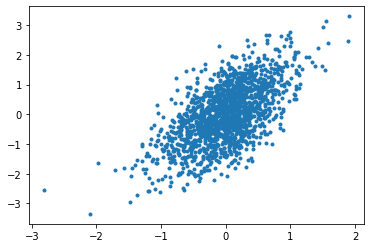

In [58]:
pred = regr.predict(X)
print('# pearson r %s, pvalue %s' % pearsonr(pred, y))
fig, ax = plt.subplots()
ax.plot(pred, y, ls='', marker='.')

# Still looks good. So what whent wrong?